In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import math
from sklearn.metrics import accuracy_score

import scipy.stats as stats
import pymc as pm
from sklearn.preprocessing import StandardScaler
import arviz as az


sns.set_style("whitegrid")

In [3]:
train_data = pd.read_csv('classify/train_clf.csv')
test_data = pd.read_csv('classify/test_clf.csv')

In [4]:
X_train = train_data[['a', 'b', 'c']]
y_train = train_data['y']
X_test = test_data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

with pm.Model() as model_1:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=2, shape=len(X_train[0]))

    μ = α_tmp + pm.math.dot(X_train, β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))

    yl = pm.Bernoulli('yl', p=θ, observed=y_train)

    trace = pm.sample(3000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 17 seconds.


In [5]:
az.summary(trace).head(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_tmp,-0.346,0.542,-1.373,0.676,0.006,0.005,8062.0,6835.0,1.0
β[0],-3.745,1.369,-6.384,-1.267,0.021,0.015,4366.0,5192.0,1.0
β[1],-3.417,1.381,-6.048,-0.875,0.021,0.015,4160.0,5269.0,1.0


array([[<Axes: title={'center': 'α_tmp'}>,
        <Axes: title={'center': 'α_tmp'}>],
       [<Axes: title={'center': 'β\n0'}>,
        <Axes: title={'center': 'β\n0'}>],
       [<Axes: title={'center': 'β\n1'}>,
        <Axes: title={'center': 'β\n1'}>],
       [<Axes: title={'center': 'β\n2'}>,
        <Axes: title={'center': 'β\n2'}>]], dtype=object)

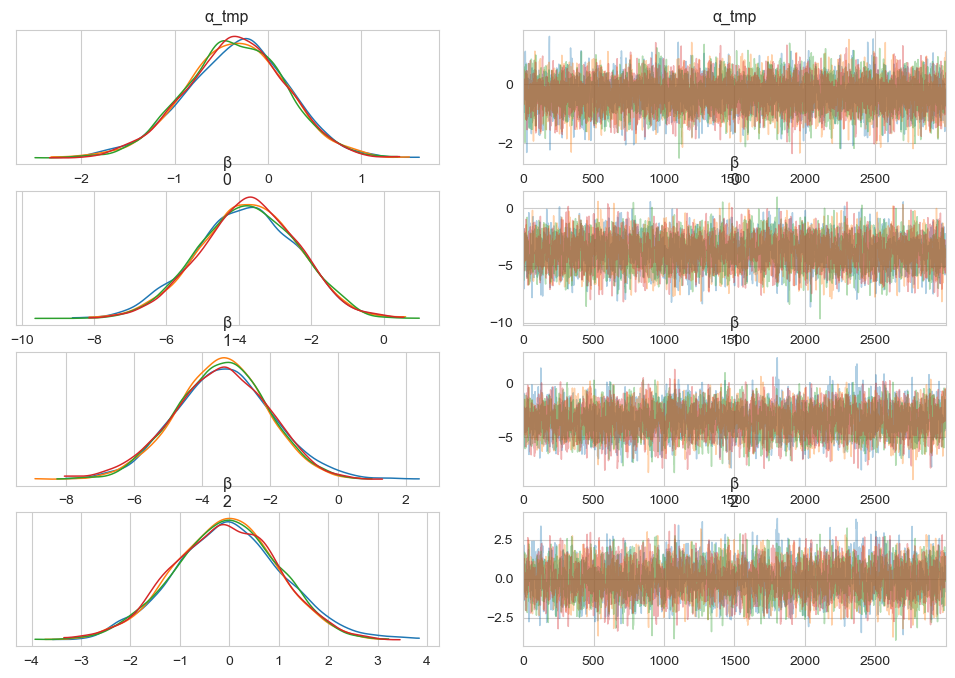

In [6]:
az.plot_trace(trace, var_names = ['α_tmp','β'], compact=False)

array([[<Axes: ylabel='β\n0'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='β\n1'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='α_tmp', ylabel='β\n2'>, <Axes: xlabel='β\n0'>,
        <Axes: xlabel='β\n1'>]], dtype=object)

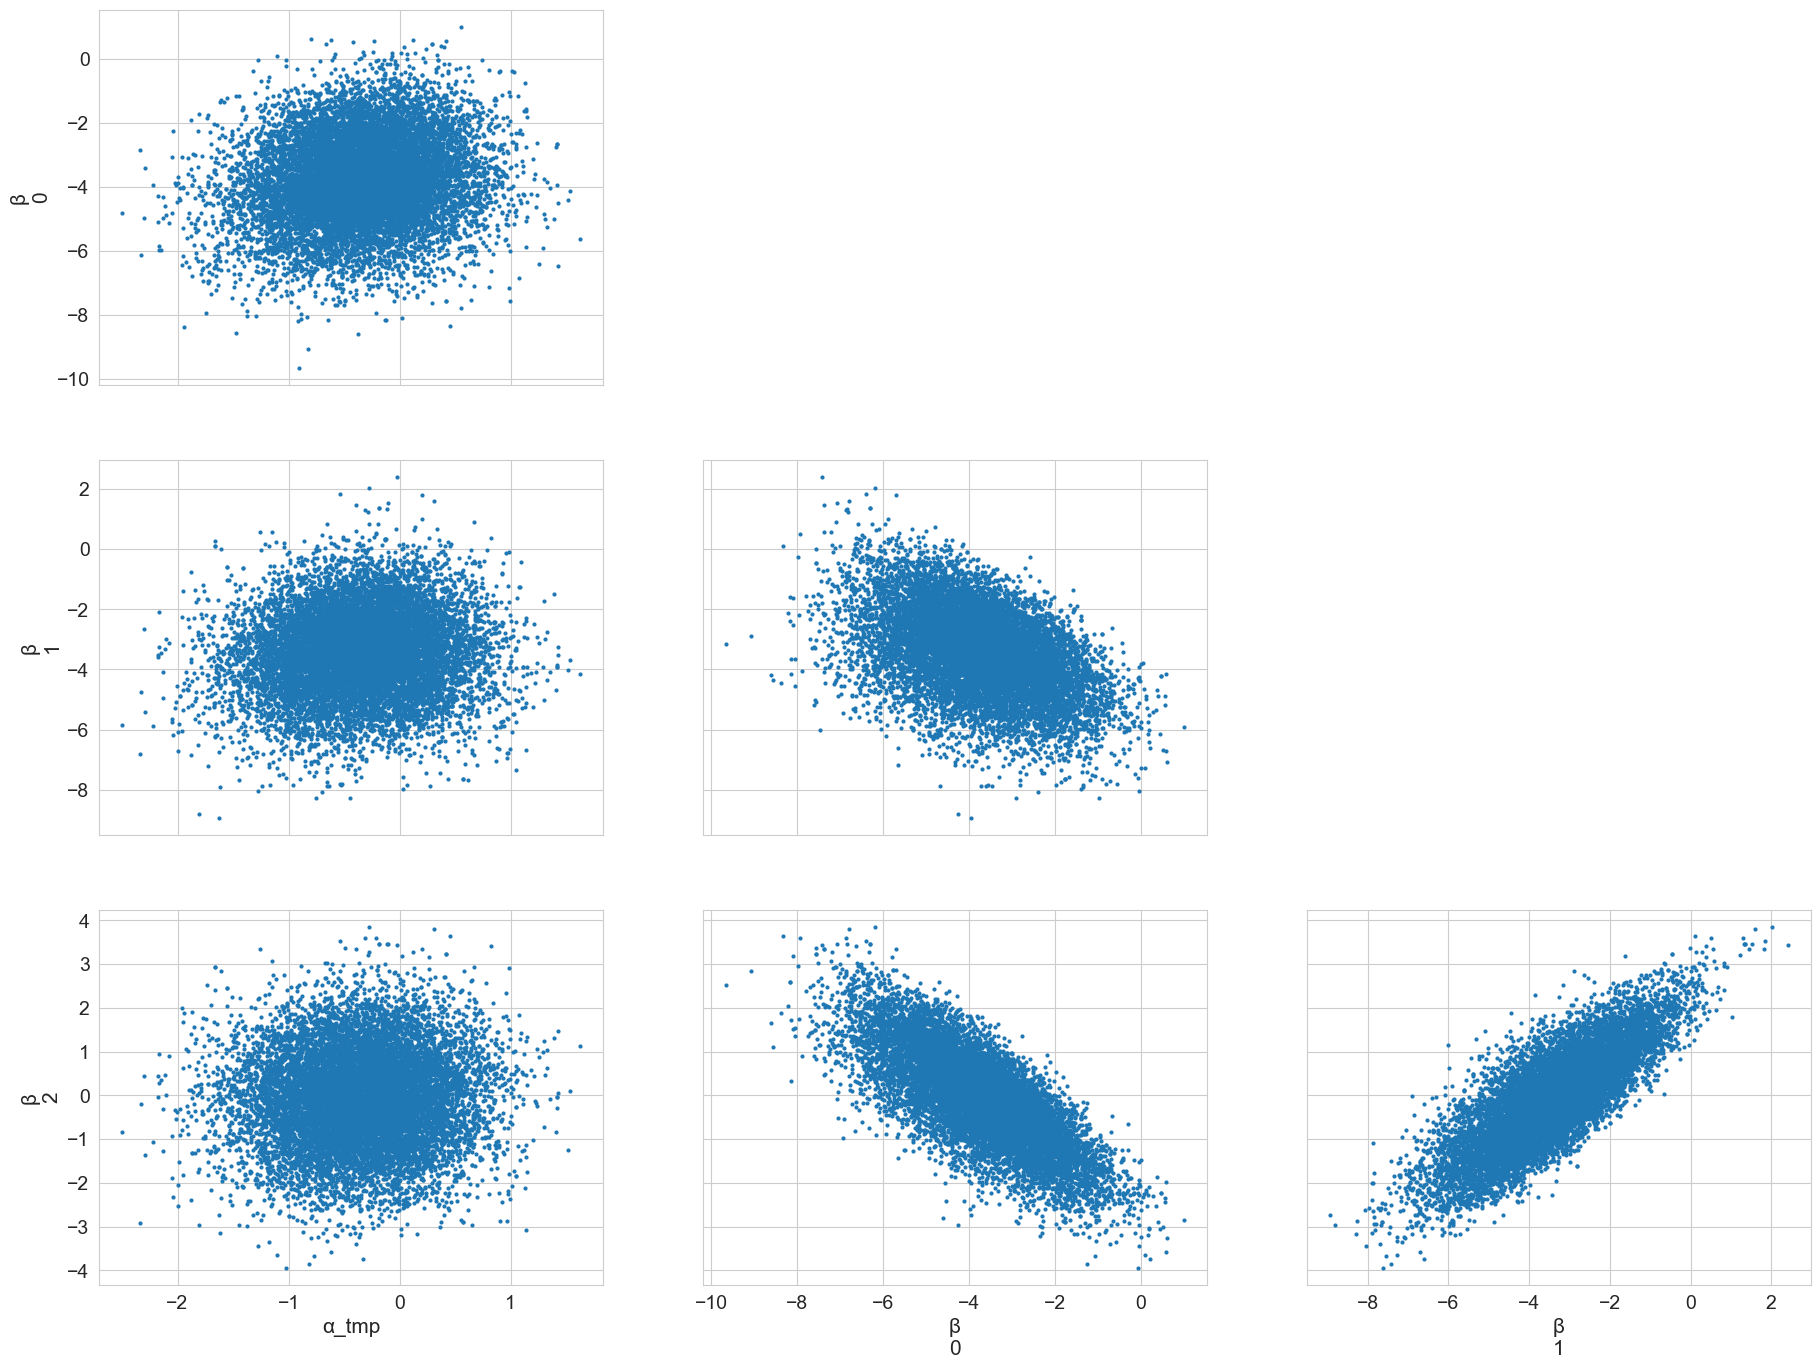

In [7]:
az.plot_pair(trace, var_names=['α_tmp', 'β'])

array([[<Axes: title={'center': 'α_tmp\n0'}>,
        <Axes: title={'center': 'α_tmp\n1'}>,
        <Axes: title={'center': 'α_tmp\n2'}>,
        <Axes: title={'center': 'α_tmp\n3'}>],
       [<Axes: title={'center': 'β\n0, 0'}>,
        <Axes: title={'center': 'β\n0, 1'}>,
        <Axes: title={'center': 'β\n0, 2'}>,
        <Axes: title={'center': 'β\n1, 0'}>],
       [<Axes: title={'center': 'β\n1, 1'}>,
        <Axes: title={'center': 'β\n1, 2'}>,
        <Axes: title={'center': 'β\n2, 0'}>,
        <Axes: title={'center': 'β\n2, 1'}>],
       [<Axes: title={'center': 'β\n2, 2'}>,
        <Axes: title={'center': 'β\n3, 0'}>,
        <Axes: title={'center': 'β\n3, 1'}>,
        <Axes: title={'center': 'β\n3, 2'}>]], dtype=object)

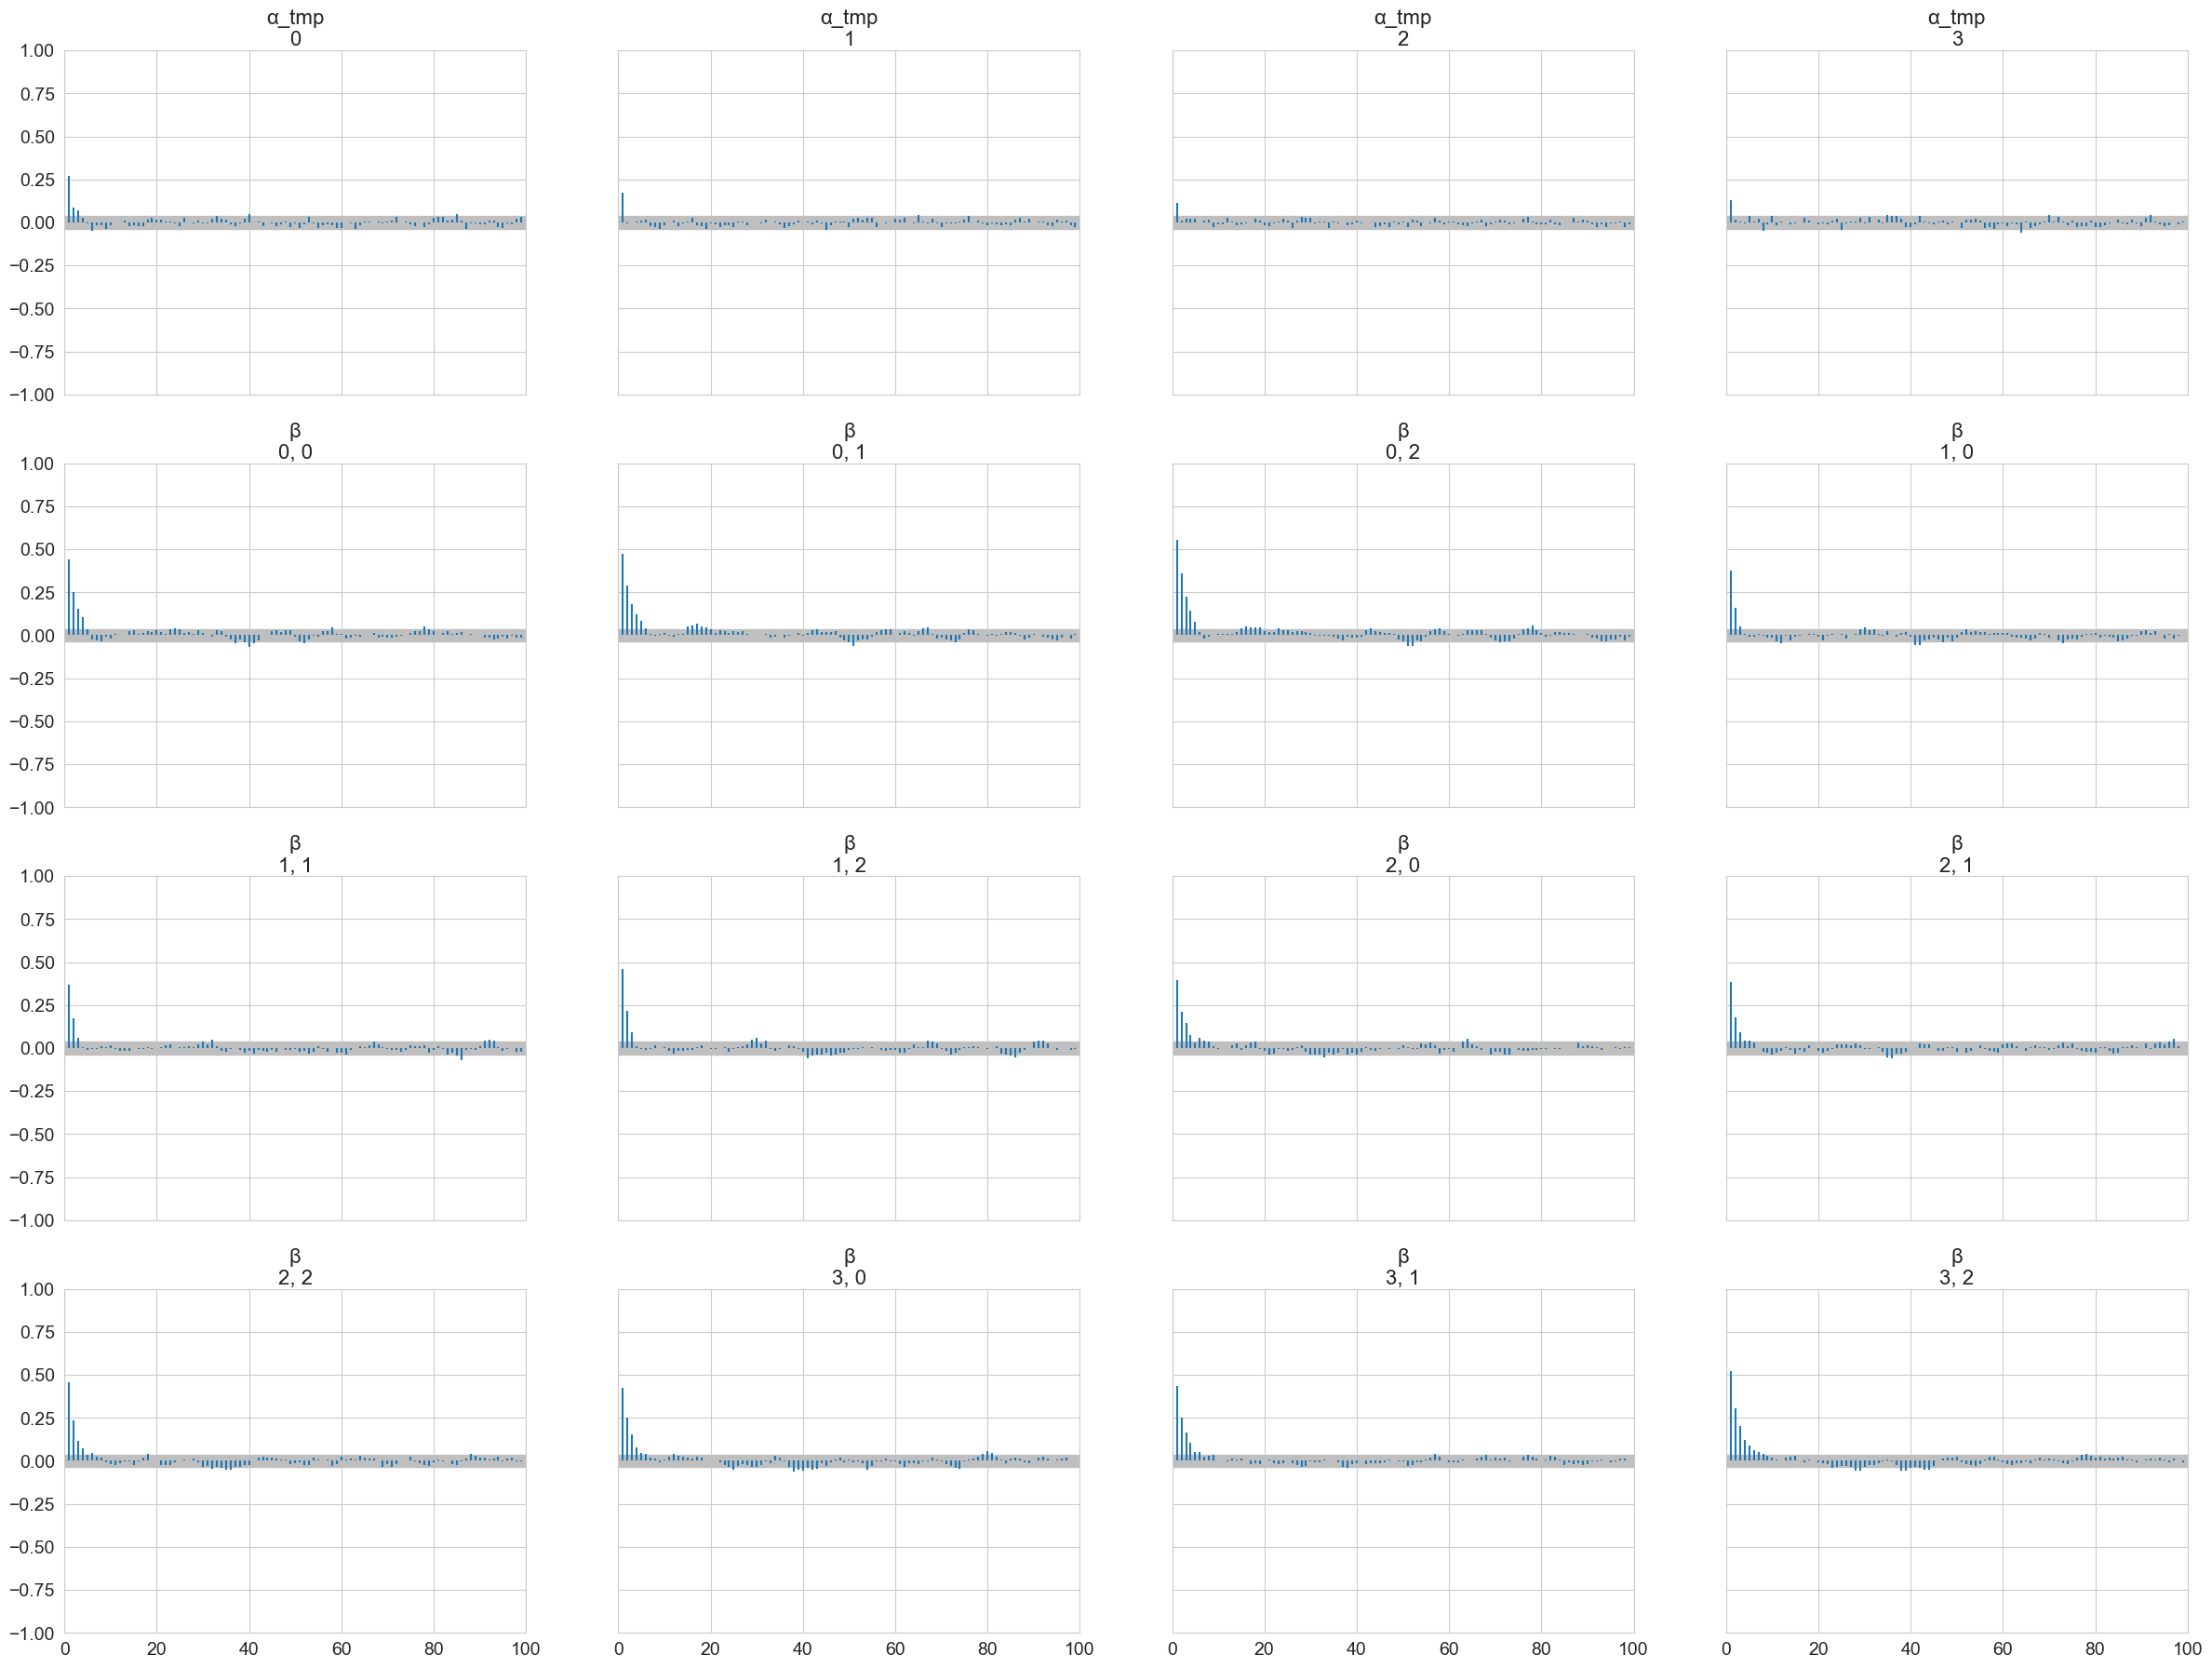

In [8]:
az.plot_autocorr(trace, ['α_tmp', 'β'])

In [9]:
α_tmp = trace.posterior['α_tmp'].mean().item()
β_1 = trace.posterior['β'].mean(axis=0).mean(axis=0)[0].item()
β_2 = trace.posterior['β'].mean(axis=0).mean(axis=0)[1].item()
β_3 = trace.posterior['β'].mean(axis=0).mean(axis=0)[2].item()

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

μ = α_tmp + β_1*X_train[:, 0] +  β_2*X_train[:, 1] + β_3*X_train[:, 2]
y_train_pred = sigmoid(μ) > 0.5

In [11]:
μ = α_tmp + β_1*X_test[:, 0] +  β_2*X_test[:, 1] + β_3*X_train[:, 2]
y_pred = sigmoid(μ) > 0.5

In [12]:
y_pred

array([False, False, False,  True,  True,  True, False,  True,  True,
       False, False,  True,  True, False,  True,  True, False,  True,
       False, False,  True, False,  True, False, False, False, False,
       False,  True,  True,  True, False, False, False,  True,  True,
        True,  True,  True, False, False,  True, False, False,  True,
        True, False, False,  True, False,  True,  True, False,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
       False, False,  True, False,  True, False,  True, False,  True,
        True, False,  True,  True, False,  True,  True,  True, False,
       False, False,  True,  True, False,  True, False,  True, False,
        True,  True,  True, False, False,  True,  True, False, False,
        True])

In [17]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_pred)

0.96

Часть 2

In [13]:
with pm.Model() as lda_model_1:
    μ_1 = pm.Normal('μ_1', mu=0, sigma=20, shape=2)
    features_1 = pm.Normal('features_1', mu=μ_1, sigma=0.68, observed=X_train[y_train == 0][:, [0, 1]])
    trace_lda_1 = pm.sample(3000, chains=4, cores=4)

with pm.Model() as lda_model_2:
    μ_2 = pm.Normal('μ_2', mu=0, sigma=20, shape=2)
    features_2 = pm.Normal('features_2', mu=μ_2, sigma=0.68, observed=X_train[y_train == 1][:, [0, 1]])
    trace_lda_2 = pm.sample(3000, chains=4, cores=4)


μ_1_mean = trace_lda_1.posterior['μ_1'].mean(axis=0).mean(axis=0)[0].item()
μ_2_mean = trace_lda_2.posterior['μ_2'].mean(axis=0).mean(axis=0)[0].item()

# Make predictions
y_train_pred_lda = np.argmin(np.column_stack([
    np.sum((X_train - μ_1_mean) ** 2, axis=1),
    np.sum((X_train - μ_2_mean) ** 2, axis=1)
]), axis=1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_1]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_2]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 14 seconds.


In [14]:
y_train_pred_lda

array([0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1])

In [16]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_train_pred_lda)

0.53